In [6]:
import hdf5_getters as GETTERS
import h5py
import glob
from pyspark.sql import SparkSession
import pyspark
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

import numpy as np
import hdf5_getters as GETTERS
import h5py
import glob
import pandas as pd
import matplotlib

#### 1. Crear la sesión con SPARK

In [1]:

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('XML ETL') \
    .master("local[*]") \
    .config('job.local.dir', 'file:/models/music-recommender-model') \
    .getOrCreate()

df = spark.range(10).toDF("number")
df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 14:32:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------+
|number|
+------+
|     0|
|     1|
|     2|
|     3|
|     4|
|     5|
|     6|
|     7|
|     8|
|     9|
+------+



In [19]:
# Stop Spark session
spark.stop()

In [15]:
df_test = spark.range(10)  # 1 millón de filas
print(df_test.count())  # Debe devolver 1,000,000

10


#### 2 - Carga del Dataset

In [9]:
df = spark.read.parquet("/opt/bitnami/spark/datasets/millionsong.parquet")

In [10]:
df = df.drop("danceability")
df.show(10)


+------------------+--------------------+--------------------+-------+---+----+--------------+--------+
|           song_id|               title|              artist|  tempo|key|mode|time_signature|loudness|
+------------------+--------------------+--------------------+-------+---+----+--------------+--------+
|SOBLFFE12AF72AA5BA|              Scream|        Adelitas Way| 99.944|  1|   1|             4|  -4.769|
|SOQPWCR12A6D4FB2A3|A Poor Recipe For...|   Western Addiction|125.475|  7|   1|             4|   -7.24|
|SOMZWCG12A8C13C480|    I Didn't Mean To|              Casual| 92.198|  1|   0|             4| -11.197|
|SOJDASC12A8C13EB49|The Lark In The C...|            Alquimia| 41.279|  2|   1|             4| -13.179|
|SOCIWDW12A8C13D406|           Soul Deep|        The Box Tops|121.274|  6|   0|             4|  -9.843|
|SOFRDWL12A58A7CEF7|        Hit Da Scene|    Quest_ Pup_ Kevo| 161.99|  6|   0|             4|  -7.227|
|SOZIULX12A8AE46C39|Come On (Album Ve...|        Super Deluxe|10

#### Entrenar el Modelo

In [4]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    'tempo',
    'loudness',
    # 'danceability',
    'key',
    'mode',
    'time_signature'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
df_assembled = assembler.transform(df)

scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

kmeans = KMeans(
    featuresCol='scaled_features',
    predictionCol='cluster_id',
    k=20,
    seed=42
)

#Cálculo de centroides
model = kmeans.fit(df_scaled)

#Ver en que centroide cae cada canción
df_with_cluster = model.transform(df_scaled)

25/07/03 14:32:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/07/03 14:32:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [5]:
df_scaled.show(1)

+------------------+------+------------+------+---+----+--------------+--------+--------------------+--------------------+
|           song_id| title|      artist| tempo|key|mode|time_signature|loudness|        features_vec|     scaled_features|
+------------------+------+------------+------+---+----+--------------+--------+--------------------+--------------------+
|SOBLFFE12AF72AA5BA|Scream|Adelitas Way|99.944|  1|   1|             4|  -4.769|[99.9440002441406...|[2.85098281878643...|
+------------------+------+------------+------+---+----+--------------+--------+--------------------+--------------------+
only showing top 1 row



#### Recomendación 

In [24]:
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeansModel

# Supongamos que tienes ya definido:
# model, scaler_model, assembler, df_scaled

# Simulamos la nueva canción
new_song = {
    'tempo': 120.0,
    'loudness': -5.0,
    'danceability': 1000,
    'key': 2.0,
    'mode': 1.0,
    'time_signature': 4.0,
    'song_id': 'NEW_SONG_ID'
}


# Convertimos a Spark DataFrame
new_song_df_pd = pd.DataFrame([new_song])
new_song_df = spark.createDataFrame(new_song_df_pd)

#  Ensamblamos y escalamos usando el pipeline original
new_song_vec = assembler.transform(new_song_df)
new_song_scaled = scaler_model.transform(new_song_vec)

# Hacemos la predicción de cluster
new_song_pred = model.transform(new_song_scaled)
predicted_cluster = new_song_pred.select(
    "cluster_id").collect()[0]["cluster_id"]

print(f"La nueva canción ha sido asignada al cluster: {predicted_cluster}")

# Buscamos canciones del dataset original en el mismo cluster

# Si no habías guardado los clusters en el df original:
df_with_cluster = model.transform(df_scaled)

# Filtramos por el mismo cluster
similar_songs = df_with_cluster.filter(
    df_with_cluster.cluster_id == predicted_cluster)

# Mostramos algunas recomendaciones (por ejemplo 3)
similar_songs.select("song_id").limit(3).show()

La nueva canción ha sido asignada al cluster: 5
+------------------+
|           song_id|
+------------------+
|SOBLFFE12AF72AA5BA|
|SONHOTT12A8C13493C|
|SOFSOCN12A8C143F5D|
+------------------+



In [14]:
metadata_df = pd.read_csv("songs_metadata.csv")

# Supongamos que estos son los song_ids recomendados que has obtenido de tu modelo
recommended_song_ids = [row['song_id']
                        for row in similar_songs.select("song_id").limit(3).collect()]


# Filtramos los metadatos para obtener nombre de la canción y artista
recommended_songs = metadata_df[metadata_df['song_id'].isin(
    recommended_song_ids)]

# Mostramos el resultado
print(recommended_songs[['song_id', 'title', 'artist']])

                song_id                              title           artist
0    SOZECOE12AB017E615  Diamonds Are A Girl's Best Friend  Gloria De Haven
84   SOPJEXC12A6D4FB529                Hot Dental Supplies      Marga Gomez
149  SOJXYFD12A8C143701         The Ferocious O' Flahertys       Joe Heaney


#### Guardar el modelo

In [15]:
from pyspark.ml import Pipeline

# Creamos el pipeline con los stages que usaste durante el entrenamiento
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# Lo ajustamos sobre el dataframe ya escalado
pipeline_model = pipeline.fit(df)

In [16]:
pipeline_model.write().overwrite().save("file:///models/music-recommender-model")

##### Guardar las canciones y a que cluster pertenecen

In [17]:
df_with_cluster.show(5)

+-------+--------+---------+----+----+--------------+------------------+--------------------+--------------------+------------------+-----------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+----------+
|  tempo|loudness| duration| key|mode|time_signature|           song_id|               title|              artist|     timbre_mean_0|     timbre_std_0|      timbre_mean_1|      timbre_std_1|      timbre_mean_2|      timbre_std_2|      timbre_mean_3|      timbre_std_3|     timbre_mean_4|      timbre_std_4|      timbre_mean_5|      timbre_std_5|      timbre_mean_6|     

In [18]:
df_export = df_with_cluster.select("title", "artist", "cluster_id")
df_export.write.csv("songs_with_cluster", header=True, mode="overwrite")

In [19]:
df_export.toPandas().to_csv("songs_with_cluster.csv", index=False)

#### Cargar el Modelo

In [5]:
from pyspark.ml import PipelineModel

loaded_model = PipelineModel.load("file:///models/music-recommender-model")

In [6]:
# Crear nueva canción con timbre simulado
new_song = {
    'tempo': 120.0,
    'loudness': -5.0,
    'danceability': 60,
    'key': 2.0,
    'mode': 1.0,
    'time_signature': 4.0,
    'track_name': 'New Song',
    'artist_name': 'Unknown Artist'
}



# Convertir a DataFrame de Spark
df_new = spark.createDataFrame(pd.DataFrame([new_song]))

# Predecir cluster directamente con el pipeline
predicted = loaded_model.transform(df_new)
predicted_cluster = predicted.select("cluster_id").collect()[0]["cluster_id"]

print(f"La canción fue asignada al cluster {predicted_cluster}")

df_with_clusters = loaded_model.transform(df_scaled)

recommendations = df_with_clusters.filter(
    df_with_clusters.cluster_id == predicted_cluster
).select("track_name", "artist_name").limit(3)

recommendations.show()


IllegalArgumentException: duration does not exist. Available: tempo, loudness, danceability, key, mode, time_signature, track_name, artist_name

In [15]:
metadata_df = pd.read_csv("songs_metadata.csv")

# Supongamos que estos son los song_ids recomendados que has obtenido de tu modelo
recommended_song_ids = [row['song_id']
                        for row in similar_songs.select("song_id").limit(3).collect()]


# Filtramos los metadatos para obtener nombre de la canción y artista
recommended_songs = metadata_df[metadata_df['song_id'].isin(
    recommended_song_ids)]

# Mostramos el resultado
print(recommended_songs[['song_id', 'title', 'artist']])

               song_id           title              artist
19  SOQBCSM12AC4687CDE  Pete's Crusade  Light Of The World


### Mejorar el modelo (Métricas)

In [12]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(
    featuresCol='scaled_features',
    predictionCol='cluster_id',
    metricName='silhouette',
    distanceMeasure='squaredEuclidean'
)

silhouette = evaluator.evaluate(df_with_cluster)
print(f"Silhouette score (k=20): {silhouette}")

Silhouette score (k=20): 0.33837674376824317


In [32]:
ks = list(range(2, 31))  # Por ejemplo, de 2 a 30 clusters

for k in ks:
    kmeans = KMeans(featuresCol='scaled_features', predictionCol='cluster_id', k=k, seed=42)
    model = kmeans.fit(df_scaled)
    df_clusters = model.transform(df_scaled)

    silhouette = evaluator.evaluate(df_clusters)
    print(f"k={k}, silhouette_score={silhouette:.4f}")

k=2, silhouette_score=0.3234


k=3, silhouette_score=0.4142


k=4, silhouette_score=0.4040


k=5, silhouette_score=0.3406


k=6, silhouette_score=0.3754


k=7, silhouette_score=0.3963


k=8, silhouette_score=0.3466


k=9, silhouette_score=0.3591


k=10, silhouette_score=0.3498


k=11, silhouette_score=0.3681


k=12, silhouette_score=0.3616


k=13, silhouette_score=0.3571


k=14, silhouette_score=0.3798


k=15, silhouette_score=0.3802


k=16, silhouette_score=0.3880


k=17, silhouette_score=0.3554


k=18, silhouette_score=0.3734


k=19, silhouette_score=0.3530


k=20, silhouette_score=0.3384


k=21, silhouette_score=0.3473


k=22, silhouette_score=0.3425


k=23, silhouette_score=0.3473


k=24, silhouette_score=0.3637


k=25, silhouette_score=0.3451


k=26, silhouette_score=0.3366


k=27, silhouette_score=0.3369


k=28, silhouette_score=0.3317


k=29, silhouette_score=0.3388


k=30, silhouette_score=0.3300


#### Que faeatures son más significativas

In [31]:
from pyspark.ml.feature import PCA

pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
model = pca.fit(df_scaled)
explained = model.explainedVariance.toArray()

for i, var in enumerate(explained):
    print(f"PC{i+1}: {var:.4f}")



PC1: 0.2542
PC2: 0.2323
PC3: 0.1915
PC4: 0.1630
PC5: 0.1590


In [1]:
!pip install matplotlib

  Using cached matplotlib-3.10.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.3.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (326 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x

25/07/02 17:26:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


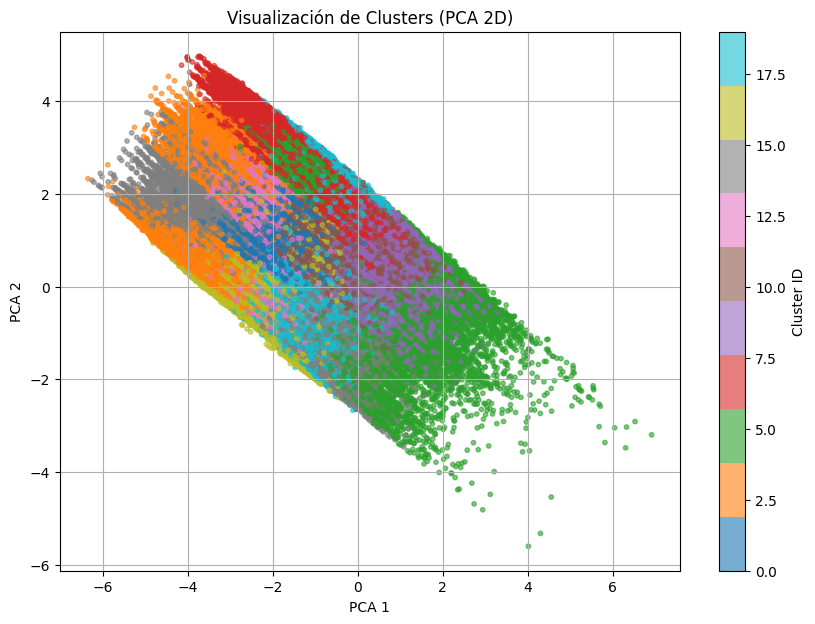

In [13]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Paso 1: Asegurarse de tener el DF con los clusters
# (df_with_cluster ya lo tienes con la columna 'cluster_id')

# Paso 2: Aplicar PCA para reducir a 2 dimensiones
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_with_cluster)
df_pca = pca_model.transform(df_with_cluster)

# Paso 3: Convertir a Pandas para graficar
df_plot = df_pca.select("pca_features", "cluster_id").toPandas()

# Extraer coordenadas PCA
pca_values = df_plot["pca_features"].apply(lambda x: x.toArray())
pca_2d = np.stack(pca_values.values)
x, y = pca_2d[:, 0], pca_2d[:, 1]

# Paso 4: Graficar con colores por cluster
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=df_plot["cluster_id"], cmap="tab10", s=10, alpha=0.6)
plt.title("Visualización de Clusters (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


In [3]:
import pandas as pd
import sweetviz as sv

df = pd.read_parquet("/opt/bitnami/spark/datasets/millionsong.parquet")
# Crear análisis
report = sv.analyze([df, "Canciones"])
# Mostrar en el navegador o notebook
report.show_html("reporte_sweetviz.html")

c:\Users\Mario\.conda\envs\TFM-UNIR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: '/opt/bitnami/spark/datasets/millionsong.parquet'

In [2]:
!pip install sweetviz


  Using cached sweetviz-2.3.1-py3-none-any.whl.metadata (24 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached sweetviz-2.3.1-py3-none-any.whl (15.1 MB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
   ---------------------------------------- 8.1/8.1 MB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 41.3/41.3 MB 5.9 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 2.2/2.2 MB 2.8 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl (71 kB)
   ---------------------------------------- 7.0/7.0 MB 3.4 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
